In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec
import string
import re
random.seed(1)
np.random.seed(1)
import rpy2.robjects as r

In [2]:
os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

## Importation de word2vec

In [3]:
nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02

In [4]:
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

# Fonctions générales

In [5]:
# On traite la mise en forme comme dans notre corpus
def mise_en_forme_phrase (phrase):
    phrase = phrase.lower()
    # On enlève la ponctuation + certaines apostrophes
    phrase = phrase.translate(str.maketrans('', '', string.punctuation + "'’«»—"))
    # On enlève les passages à la ligne
    phrase = re.sub('\\n', ' ', phrase)
    # On enlève les tabulations
    phrase = re.sub('\\t', ' ', phrase)
    # On enlève les espaces multiples et les espaces à la fin des phrases
    phrase = re.sub(' +', ' ', phrase)
    phrase = re.sub(' +$', '', phrase)
    phrase = re.sub('^ +', '', phrase)
    # phrase.isalpha() # inutile
    return(phrase)

In [6]:
def calcul_sentence_embedding(phrase,lowfrequency_zero,pond=False):
    
    if len(phrase)>0: 
        if(pond): #Modèle de la fin non utilisé
            sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                return  (sum1)/(len([mot for mot in phrase if mot in model1.wv.index2word]))
        else:     
            sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
            #sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                #sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                taille = len([mot for mot in phrase if mot in model1.wv.index2word])
                if taille>0:
                    return  (sum1)/taille
                else: 
                    return 'NaN'
    else:
        if lowfrequency_zero==False:
            return matrice["lowfrequencyword"]
        else:
            return 'NaN'

In [7]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [11]:
def creer_indice(modeles,rmsws,mot_rares,git_strings):
    
    resultat = pd.DataFrame(columns=[''])
    
    #fichiers des modeles
    #if(isinstance(modele, list)):
    #modele = r.r['paste0']("(",r.r['paste0']("(",modele,")",collapse = "|"),")")[0]
    #if(isinstance(rmsw, list)):
    #rmsw = r.r['paste0']("(",r.r['paste0']("(",rmsw,")",collapse = "|"),")")[0]
    #if(isinstance(mot_rare, list)):
    #mot_rare = r.r['paste0']("(",r.r['paste0']("(",mot_rare,")",collapse = "|"),")")[0]
    #requete_regexp = 'reg_{}_{}_{}'.format(modele,rmsw,mot_rare)
    #fichiers_modeles = r.r['list.files'](path = 'data/sentimental_analysis/',
    #                  pattern = requete_regexp)
    #requete_regexp = 'reg_{}_{}_{}'.format(modele,rmsw,mot_rare)
    
    #fichiers de tweets mensuels
    fichiers_tweets = []
    for i in range(2011,2019):
        for j in range(1,13): #range(1,13) normalement (là je fais tourner petit à petit car long)
            if j < 10:
                mot = "0"+str(j)
            else:
                mot = str(j)
            fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))
    for modele in modeles:
        for rmsw in rmsws:
            for mot_rare in mot_rares:
                for git_string in git_strings:
                    regression = 'reg_{}_{}_{}{}'.format(modele,rmsw,mot_rare,git_string)
                    chemin = "data/sentimental_analysis/{}.file".format(regression)
                    if mot_rare=="z":
                        lowfrequency_zero_bool = True
                    else:
                        lowfrequency_zero_bool = False

                    with open(chemin, "rb") as f:
                        reg  = pickle.load(f)
                    resultat[regression] = 0
                    print(regression)
                    for nom in fichiers_tweets:
                        print(nom)
                        df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
                        df.columns = ['tweet']
                        if rmsws=="rmsw":
                            phrases = [suppr_stop(mise_en_forme_phrase(ligne.tweet).split()) for ligne in df.itertuples()]
                        else:
                            phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
                        phrases_emb = [calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool) for phrase in phrases]
                        phrases_emb = [phrase for phrase in phrases_emb if phrase != 'NaN']
                        Y = reg.predict(phrases_emb)
                        Y_bis = [max(val,0) for val in Y]
                        resultat.loc[nom[0:7],regression] = [np.mean(Y_bis)]
    return resultat

# Calcul des indices mensuels (étape à ne pas refaire ultérieurement)

In [12]:
#resultat = creer_indice(modeles = ["log","prob"],rmsws = ["rmsw","nrmsw"],mot_rares = ["z","lf"],git_strings=["","_sncf"])
resultat = creer_indice(modeles = ["log"],rmsws = ["nrmsw"],mot_rares = ["lf"],git_strings=["","_sncf"])

C:\Users\torna\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


reg_log_nrmsw_lf
2011-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\torna\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


reg_log_nrmsw_lf_sncf
2011-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-01-01


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-02-02


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-03-03


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-04-04


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-05-05


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-06-06


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-07-07


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-08-08


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-09-09


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-10-10


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-11-11


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-12-12


C:\Users\torna\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [13]:
# sauver en .file
#with open("data/sentimental_analysis/index_git_sncf_modele_final.file", "wb") as f:
#    pickle.dump(resultat, f, pickle.HIGHEST_PROTOCOL)

In [14]:
# sauver en csv
#resultat.to_csv("index_git_sncf_modele_final.csv",sep=";")

# Indice mensuel avec la baseline

In [20]:
def calcul_sentence_embedding_baseline(tweet, matrice_sentiments_val):
    sum1 = sum(matrice_sentiments_val[mot] for mot in tweet if mot in matrice_sentiments_val.keys())
    sum2 = sum(1 for mot in tweet if mot in matrice_sentiments_val.keys())
    if sum2 > 0:
        return sum1/sum2
    else:
        return 0

In [21]:
with open("data/sentimental_analysis/matrice_sentiment_baseline_git.file", "rb") as f:
    matrice_sentiment_git = pickle.load(f)
with open("data/sentimental_analysis/matrice_sentiment_baseline_sncf.file", "rb") as f:
    matrice_sentiment_sncf = pickle.load(f)

In [24]:
def creation_indice_baseline():
    resultat = pd.DataFrame(columns=[''])
    fichiers_tweets = []
    for i in range(2011,2019):
        for j in range(1,13):
            if j < 10:
                mot = "0"+str(j)
            else:
                mot = str(j)
            fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))
    matrice = {"git":matrice_sentiment_git,
              "sncf":matrice_sentiment_sncf}
    for val_mat in matrice.keys():
        if val_mat=="git":
             seuil = -0.05 #seuil git
        else:
            seuil = -0.14 #seuil sncf
        for nom in fichiers_tweets:
            print(nom)
            df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
            df.columns = ['tweet']
            phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
            phrases_emb = [calcul_sentence_embedding_baseline(phrase,matrice[val_mat]) for phrase in phrases]
            Y = [1 if val > seuil else 0 for val in phrases_emb] 
            resultat.loc[nom[0:7],val_mat] = [np.mean(Y)]
    return resultat

In [ ]:
res = creation_indice_baseline()

In [ ]:
index_brut = pd.read_csv("data/sentimental_analysis/camme_brut.csv",sep=';',header=0,engine='python',encoding='UTF-8')

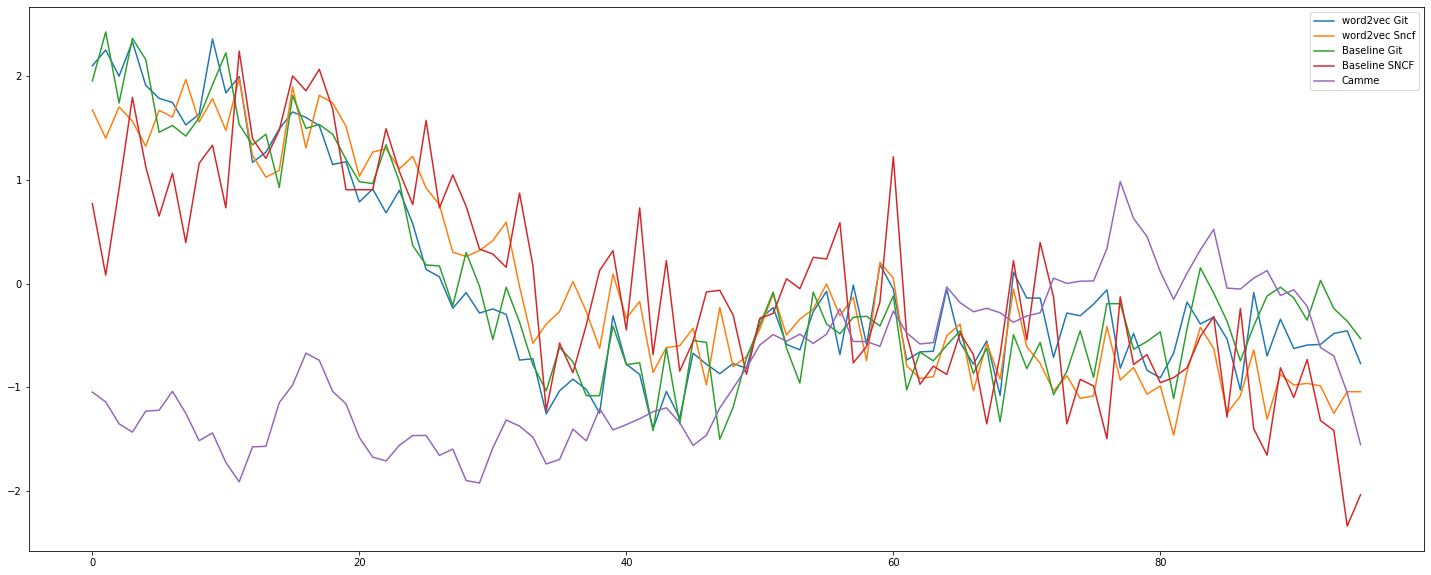

In [34]:
from sklearn.preprocessing import scale
plt.figure(figsize = (25, 10))
plt.plot(scale(resultat['reg_log_nrmsw_lf']))
plt.plot(scale(resultat['reg_log_nrmsw_lf_sncf']))
plt.plot(scale(res['git']))
plt.plot(scale(res['sncf']))
plt.plot(index_brut['ind_synth_brut'])
plt.legend(["word2vec Git","word2vec Sncf","Baseline Git","Baseline SNCF","Camme"])

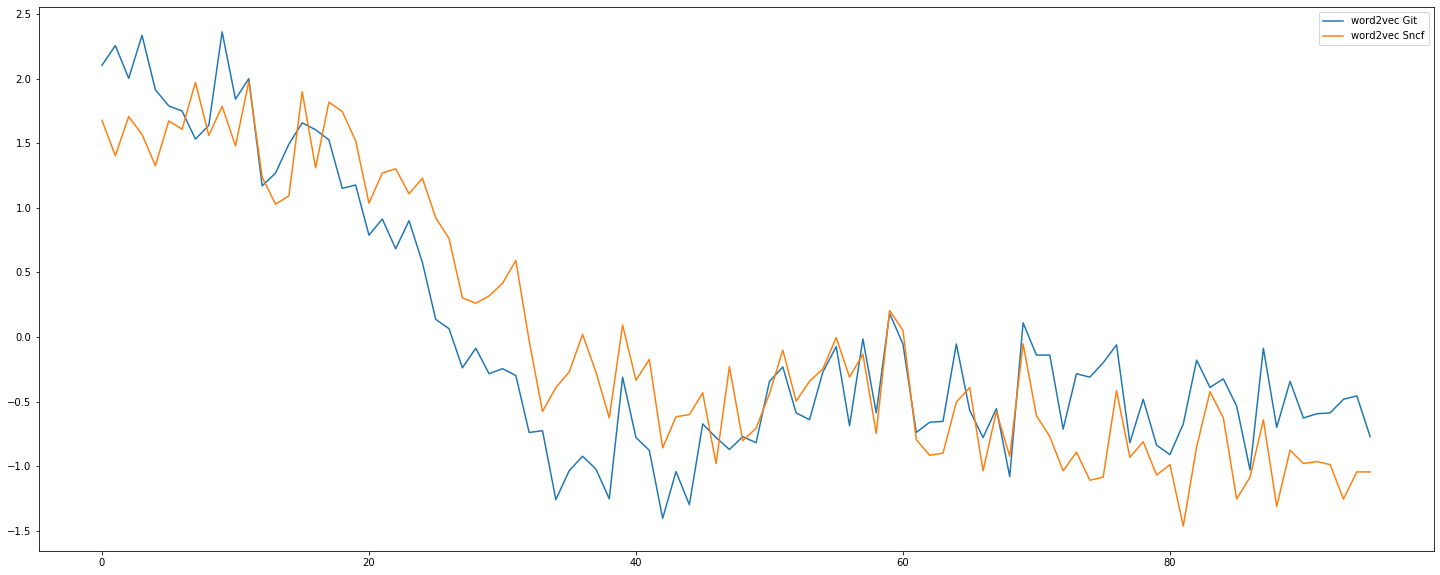

In [35]:
from sklearn.preprocessing import scale
plt.figure(figsize = (25, 10))
plt.plot(scale(resultat['reg_log_nrmsw_lf']))
plt.plot(scale(resultat['reg_log_nrmsw_lf_sncf']))
plt.legend(["word2vec Git","word2vec Sncf"])

### Tests Romain mots inconnus etc.

In [ ]:
nb_mots = 0
nb_mots_inc= 0
fichiers_tweets = []
mots_inconnus = []
for i in range(2011,2019):
    for j in range(1,13):
        if j < 10:
            mot = "0"+str(j)
        else:
            mot = str(j)
        fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))
for nom in fichiers_tweets:
    print(nom)
    df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
    df.columns = ['tweet']
    phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
    mots = [item for sublist in phrases for item in sublist if item not in model1.wv.index2word]
    mots_inconnus += mots

In [18]:
vocabulaire_inc = list(dict.fromkeys(mots_inconnus))

In [20]:
with open("data/sentimental_analysis/vocabulaire_inc.file", "wb") as f:
        pickle.dump(vocabulaire_inc, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
nb_mots_w2 = 0
nb_mots_inc_w2 = 0
for nom in fichiers_tweets:
    print(nom)
    df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
    df.columns = ['tweet']
    phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
    for phrase in phrases:
        for mot in phrase:
            nb_mots_w2 += 1
            if mot not in model1.wv.index2word:
                nb_mots_inc_w2 += 1

In [23]:
print(nb_mots_w2)
print(nb_mots_inc_w2)

4835447
655965


In [ ]:
nb_mots_tot = 0
nb_mots_inc_tot = 0
for nom in fichiers_tweets:
    print(nom)
    df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
    df.columns = ['tweet']
    phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
    for phrase in phrases:
        for mot in phrase:
            nb_mots_tot += 1
            if mot not in matrice_sentiment_sncf.keys() or mot not in model1.wv.index2word:
                nb_mots_inc_tot += 1

In [25]:
print(nb_mots_tot)
print(nb_mots_inc_tot)

4835447
1018464


In [48]:
fichiers_tweets = []
for i in range(2011,2019):
    for j in range(1,13):
        if j < 10:
            mot = "0"+str(j)
        else:
            mot = str(j)
        fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))

In [49]:
phrases_tot = []
for nom in fichiers_tweets:
    #print(nom)
    df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
    df.columns = ['tweet']
    phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
    for phrase in phrases:
        phrases_tot += [phrase]

In [50]:
mots_tot = [item for sublist in phrases_tot for item in sublist]

In [51]:
vocabulaire_tot = list(dict.fromkeys(mots_tot))

In [52]:
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)
phrases_train = [tweet.split() for (score, tweet) in corpus_train]
mots_train = [item for sublist in phrases_train for item in sublist]
vocabulaire_train = list(dict.fromkeys(mots_train))

In [57]:
test = list(set(vocabulaire_tot).intersection(vocabulaire_train))

In [58]:
len(test)

18972

In [59]:
print((len(vocabulaire_tot) - len(test))/len(vocabulaire_tot))

0.9627559644049729


In [60]:
len(vocabulaire_tot)

509397

In [65]:
test = list(set(vocabulaire_tot).intersection(model1.wv.index2word))
print((len(vocabulaire_tot) - len(test))/len(vocabulaire_tot))

0.8880107264078901


In [ ]:
test1 = list(set(vocabulaire_tot).intersection(model1.wv.index2word))
voc1 = [mot for mot in vocabulaire_tot if mot not in test1]

In [82]:
test2 = list(set(vocabulaire_tot).intersection(vocabulaire_train))
voc2 = [mot for mot in vocabulaire_tot if mot not in test2]

In [83]:
test = list(dict.fromkeys(voc1 + voc2))
print(len(test)/len(vocabulaire_tot))

0.9692067287400593
